In [2]:
!pip install imblearn

  Using cached imbalanced_learn-0.9.1-py3-none-any.whl (199 kB)
  Using cached scikit_learn-1.1.3-cp39-cp39-win_amd64.whl (7.6 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.1
    Uninstalling scikit-learn-1.0.1:
      Successfully uninstalled scikit-learn-1.0.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
skforecast 0.5.1 requires scikit-learn<=1.1,>=1.0, but you have scikit-learn 1.1.3 which is incompatible.
skforecast 0.5.1 requires statsmodels<=0.13,>=0.12, but you have statsmodels 0.13.5 which is incompatible.
allennlp 2.10.0 requires protobuf==3.20.0, but you have protobuf 3.19.6 which is incompatible.


In [3]:
# Temel İşlemler
import pandas as pd
import numpy as np

# Görselleştirme
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=1.5, rc={'lines.linewidth':1.5})

# Dengesiz hedef değişken dağılımı için arttırımlar
from imblearn.over_sampling import SMOTE

# train test split
from sklearn.model_selection import train_test_split,GridSearchCV

# model
from sklearn.linear_model import LogisticRegression


# Sayma için gerekli
from collections import Counter

# Doğruluk ölçütleri
from sklearn.metrics import plot_confusion_matrix,confusion_matrix,accuracy_score,mean_squared_error,classification_report
from sklearn.metrics import roc_auc_score,f1_score,precision_score,recall_score,r2_score,mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

In [4]:
data = pd.read_csv('healthcare-dataset-stroke-data.csv')
data.drop('id', axis=1, inplace=True)
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


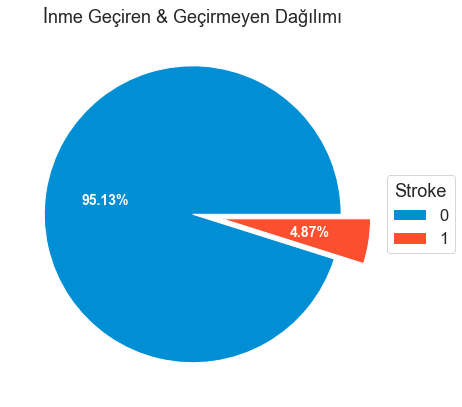

In [5]:
pie_data = data['stroke'].value_counts(normalize=True).values * 100
pie_label = data['stroke'].value_counts(normalize=True).index

fig, ax = plt.subplots(figsize=(8,6))

wedges, texts, autotexts = ax.pie(pie_data, startangle=0, explode=[0, 0.2],
                                  autopct='%.2f%%', textprops={'color':'w', 'fontsize':14, 'weight':'bold'})

ax.legend(wedges, pie_label,
          title='Stroke',
          loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('İnme Geçiren & Geçirmeyen Dağılımı')
plt.tight_layout()
plt.show()

In [6]:
# Other cinsiyetini en çok tekrar eden değer ile değiştiriyorum
data['gender'] = data['gender'].replace(to_replace = 'Other',value='Male',regex=True)

data['bmi'].fillna(data['bmi'].median(), inplace=True)

data.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

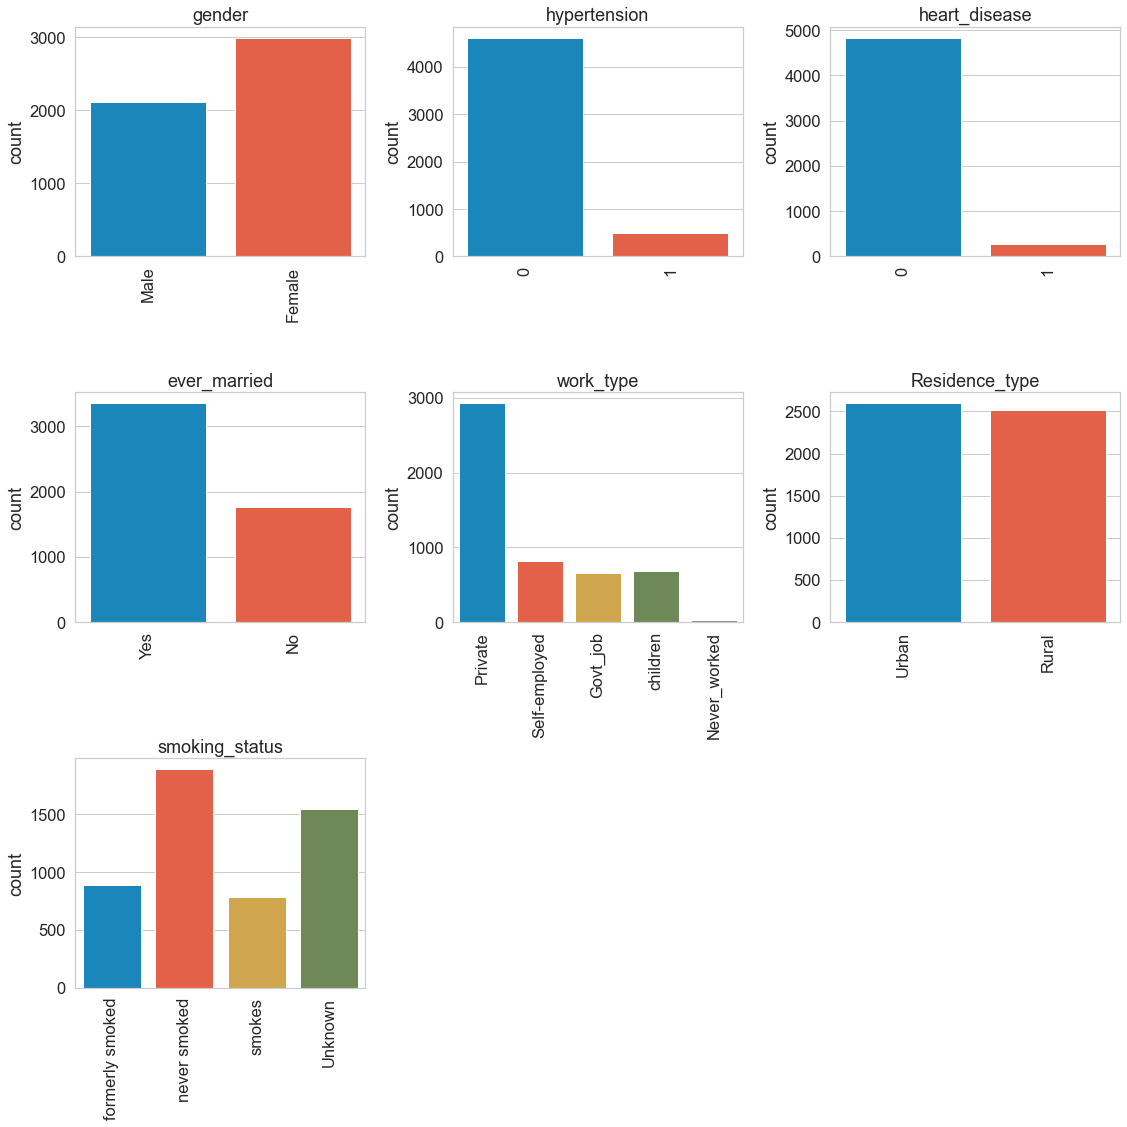

In [7]:
column_categorical = ['gender', 'hypertension', 'heart_disease', 'ever_married',
                      'work_type', 'Residence_type', 'smoking_status']

fig, ax = plt.subplots(3,3,figsize=(16,16))
axes_list = [axes for axes_row in ax for axes in axes_row]

for i, col in enumerate(column_categorical):
    
    sns.countplot(data=data, x=col, ax=axes_list[i])
    axes_list[i].set_xlabel('')
    axes_list[i].set_title(col)
    plt.setp(axes_list[i].get_xticklabels(), rotation=90)

axes_list[-2].set_visible(False)
axes_list[-1].set_visible(False)

plt.tight_layout()
plt.show()

In [8]:
# Other cinsiyetini en çok tekrar eden değer ile değiştiriyorum
data['gender'] = data['gender'].replace(to_replace = 'Other',value='Male',regex=True)

In [10]:
def stacked_bar_plot(data, x, y):

    fig, ax = plt.subplots(figsize=(8,6))

    crosstab = pd.crosstab(index=data[x], columns=data[y], normalize='index')

    crosstab.plot(kind='bar', stacked=True, ax=ax)

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title=y)
    ax.set_ylabel('')
    ax.set_yticks(np.linspace(0,1,11))
    ax.set_yticks([])
    ax.set_ylabel(' ')
    ax.set_xlabel(' ')
    for n, x in enumerate(crosstab.index):
        for (proportion, y_loc) in zip(crosstab.loc[x], crosstab.loc[x].cumsum()):
              ax.text(x=n,
              y=(y_loc - proportion) + (proportion / 2),
              s=f'{np.round(proportion * 100, 1)}%',
              color='black',
              fontsize=14,
              fontweight='bold',
              horizontalalignment='center',
              verticalalignment='center')

plt.show()

<p style="font-family: Arial; font-size:3.4em;color:black;"> Yorumlama </p>

#### **<font color='green'>Hiç sigara içmeyen bir hastanın inme geçirmeme olasılığı en yüksektir</font>**
* <p style="font-family: Arial; font-size:1.1em;color:#0080ff;">Bilinmeyen ve daha önce inme geçirmemiş kişileri, daha önce sigara kullanmamış kategorisine alınarak veri bütünlüğü sağlanacaktır </p>

#### **<font color='red'>Daha önce sigara içen bir hastanın inme geçirme olasılığı en yüksektir</font>**

* <p style="font-family: Arial; font-size:1.1em;color:#0080ff;">Bilinmeyen ve daha önce inme geçirmiş kişileri, daha önce sigara kullanmış kategorisine alınarak veri bütünlüğü sağlanacaktır </p>

In [11]:
mask = (data['stroke'] == 1) & (data['smoking_status'] == 'Unknown')
data.loc[mask, 'smoking_status'] = 'formerly smoked'

In [12]:
mask = (data['stroke'] == 0) & (data['smoking_status'] == 'Unknown')
data.loc[mask, 'smoking_status'] = 'never smoked'

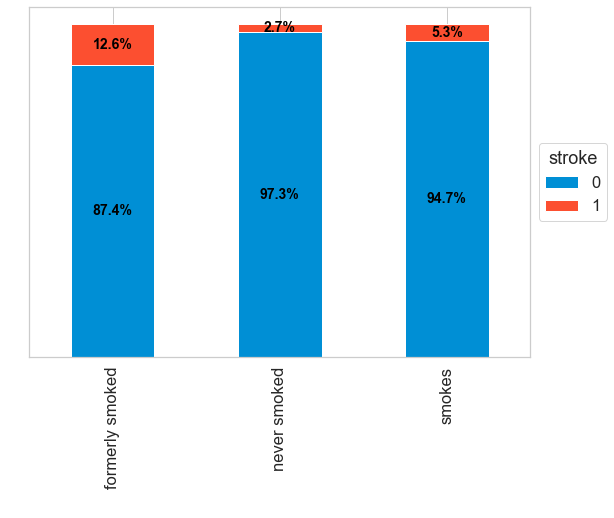

In [13]:
#Sigara türlerine göre inme oranları
stacked_bar_plot(data,"smoking_status","stroke")

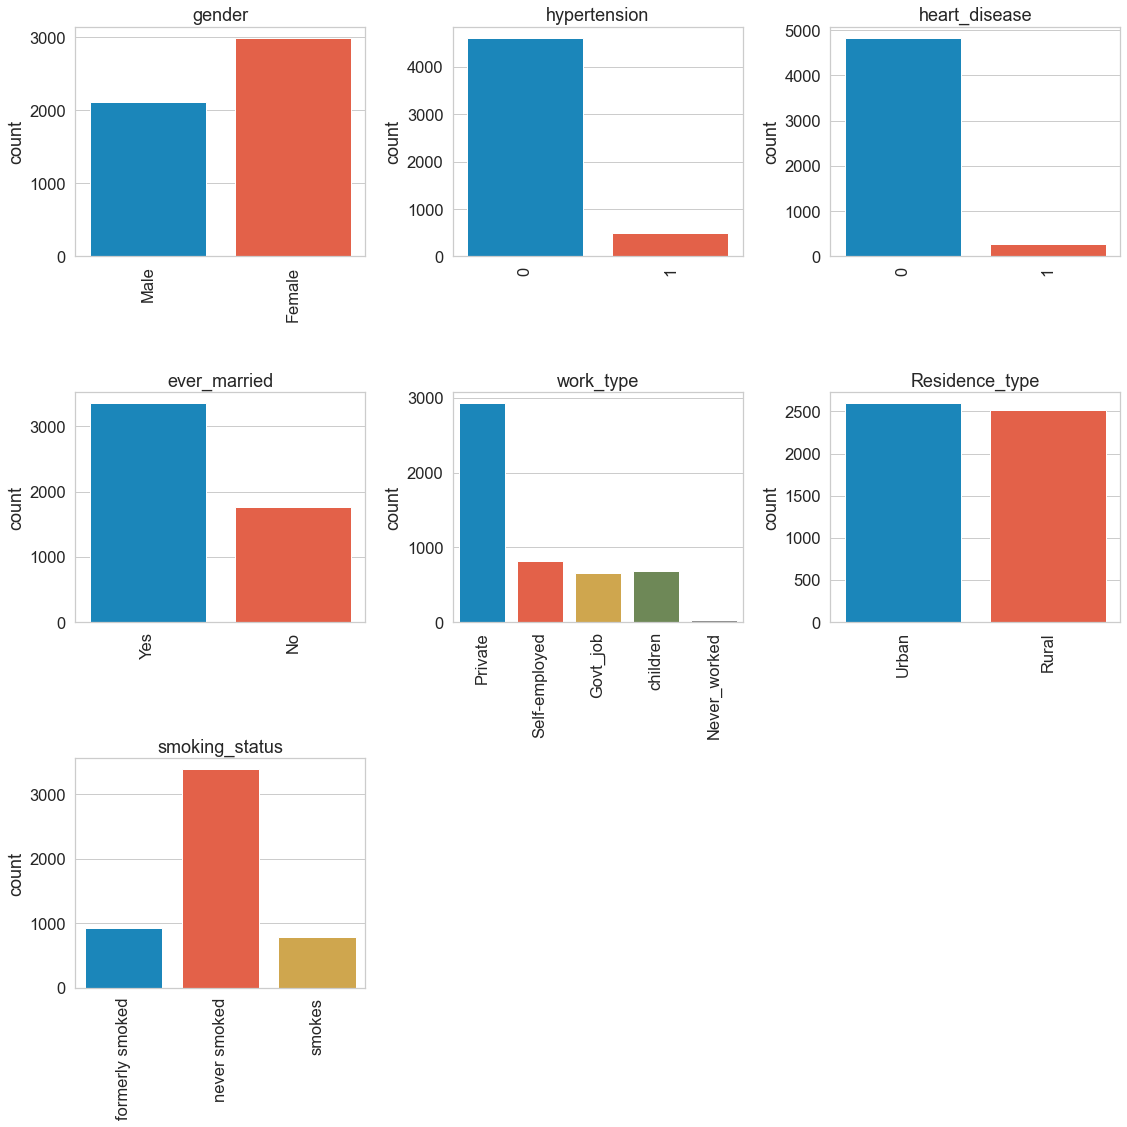

In [14]:
column_categorical = ['gender', 'hypertension', 'heart_disease', 'ever_married',
                      'work_type', 'Residence_type', 'smoking_status']

fig, ax = plt.subplots(3,3,figsize=(16,16))
axes_list = [axes for axes_row in ax for axes in axes_row]

for i, col in enumerate(column_categorical):
    
    sns.countplot(data=data, x=col, ax=axes_list[i])
    axes_list[i].set_xlabel('')
    axes_list[i].set_title(col)
    plt.setp(axes_list[i].get_xticklabels(), rotation=90)

axes_list[-2].set_visible(False)
axes_list[-1].set_visible(False)

plt.tight_layout()
plt.show()

# Regression

In [15]:
data = pd.get_dummies(data,columns=['gender','ever_married','work_type','Residence_type','smoking_status'],drop_first=True)
data.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,ever_married_Yes,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,1,1,0,1,0,0,1,0,0
1,61.0,0,0,202.21,28.1,1,0,1,0,0,1,0,0,1,0
2,80.0,0,1,105.92,32.5,1,1,1,0,1,0,0,0,1,0
3,49.0,0,0,171.23,34.4,1,0,1,0,1,0,0,1,0,1
4,79.0,1,0,174.12,24.0,1,0,1,0,0,1,0,0,1,0


In [16]:
y = data["stroke"]# Bağımsız Değişken 
X = data.drop(['stroke'],axis=1) # Bağımlı Değişken

# Stats Model: OLS İle Regression
* Sıradan en küçük kareler yöntemidir. Doğrusal regresyon modeli kurulurken verilerin ortasından geçen eğime (çizgiye) en az kare farkı ile yaklaşmaya çalışan bir yöntemdir.

In [17]:
import statsmodels.api as sm
X = sm.add_constant(X)
# Modelin çalıştırılması
model = sm.OLS(y,X).fit()
# Modelin yorumlanacağı tablo
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 stroke   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     39.25
Date:                Sat, 26 Nov 2022   Prob (F-statistic):          1.56e-102
Time:                        17:12:34   Log-Likelihood:                 858.52
No. Observations:                5110   AIC:                            -1687.
Df Residuals:                    5095   BIC:                            -1589.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [18]:
# Modelin tahmin
y_pred_stat = model.predict(X)

# Gerçek gelir değerleri ile tahmin edilen gelir değerlerinin birleştirilmesi
karsilastirma = pd.DataFrame({'Gercek_Degerler': y, 'Tahmin_Degerler': y_pred_stat}).sort_index()

# Gerçek değer ile tahmin edilen değer arasındaki hata
karsilastirma["tahminleme_hatalari"] = karsilastirma['Gercek_Degerler'] - karsilastirma['Tahmin_Degerler']
print('Ortalama Kare Hatası:', mean_squared_error(karsilastirma['Gercek_Degerler'], karsilastirma['Tahmin_Degerler']))
print("r2 score",r2_score(karsilastirma['Gercek_Degerler'], karsilastirma['Tahmin_Degerler']))
karsilastirma.head()

Ortalama Kare Hatası: 0.041840488791535145
r2 score 0.09736206511010526


,Gercek_Degerler,Tahmin_Degerler,tahminleme_hatalari
0,1,0.226236,0.773764
1,1,0.071587,0.928413
2,1,0.158279,0.841721
3,1,0.066692,0.933308
4,1,0.157308,0.842692


# Sckitlearn Logistic Regression Model

In [19]:
# Tahmin ve Doğrulama İçin veri Setini ayarlama
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42,shuffle=True,stratify=y)

In [20]:
# Tahmin ve Doğrulama İçin veri Setini ayarlama
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42,shuffle=True,stratify=y)

# lojistik regresyon nesnesinin çağırılması
lr = LogisticRegression()

# veri setine fit etme işlemi
lr.fit(X_train,y_train)

# öğrenilen modelin test verisine uygulanması
y_pred = lr.predict(X_test)

print(classification_report(y_test, y_pred))
#print("R2 Score:",r2_score(y_test, y_pred))
print("Mean Absolute:",mean_absolute_error(y_test, y_pred))
print("Mean Squared:",mean_squared_error(y_test, y_pred))
print("Doğruluk Skoru:",accuracy_score(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       972
           1       1.00      0.02      0.04        50

    accuracy                           0.95      1022
   macro avg       0.98      0.51      0.51      1022
weighted avg       0.95      0.95      0.93      1022

Mean Absolute: 0.04794520547945205
Mean Squared: 0.04794520547945205
Doğruluk Skoru: 0.952054794520548


### TP (True positive — Doğru Pozitif): Hastaya hasta demek.
### FP (False positive — Yanlış Pozitif): Hasta olmayana hasta demek.
### TN (True negative — Doğru Negatif): Hasta olmayana hasta değil demek.
### FN (False negative — Yanlış Negatif): Hasta olana hasta değil demek.

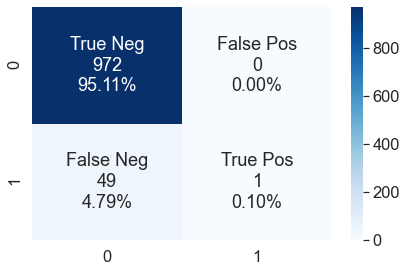

In [21]:
cf_matrix = confusion_matrix(y_test,y_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}"for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.show()

### **SMOTE(Synthetic Minority Over-Sampling Technique):** Sentetik veri üretilmesini sağlayan bir aşırı örnekleme sürecidir.

In [22]:
counter = Counter(y_train)
print('Öncesi',counter)
# Veri artırımı --> using SMOTE
smt = SMOTE()
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)

counter = Counter(y_train_sm)
print('Sonrası',counter)

Öncesi Counter({0: 3889, 1: 199})
Sonrası Counter({0: 3889, 1: 3889})


In [24]:
logreg = LogisticRegression(solver = 'liblinear')

model = GridSearchCV(logreg, n_jobs=1,cv = 2, param_grid = {
    'penalty': ('l1', 'l2'),
    'C': [0.5, 0.6, 0.7, 0.8, 0.9,1,1.5],
    'max_iter': [100,200,300]
})

model.fit(X_train_sm, y_train_sm)
best_model = model.best_estimator_
print("hyper:",model.best_params_)
print("İyi parametre katsayıları",best_model.coef_ )
y_pred = model.predict(X_test)

hyper: {'C': 1.5, 'max_iter': 100, 'penalty': 'l1'}
İyi parametre katsayıları [[-1.50045053  0.0975625  -0.49387097 -1.26187927  0.00681924  0.01191597
  -1.04488602 -1.11496743  0.         -1.43596892 -2.59297797 -1.52901013
  -0.86451548 -2.86603024 -1.93535327]]


In [25]:
print(classification_report(y_test,y_pred),"\n")
print("Doğruluk Skoru:",accuracy_score(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.87      0.92       972
           1       0.17      0.54      0.26        50

    accuracy                           0.85      1022
   macro avg       0.57      0.70      0.59      1022
weighted avg       0.93      0.85      0.89      1022
 

Doğruluk Skoru: 0.8512720156555773


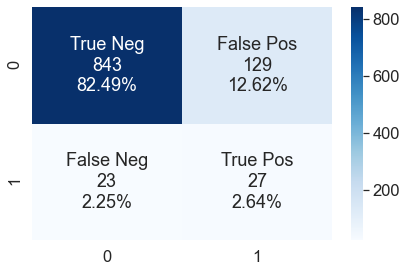

In [26]:
# öğrenilen modelin test verisine uygulanması
cf_matrix1 = confusion_matrix(y_test,y_pred)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix1.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix1.flatten()/np.sum(cf_matrix1)]
labels = [f"{v1}\n{v2}\n{v3}"for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix1, annot=labels, fmt='', cmap='Blues')
plt.show()

In [28]:
karsilastirma = pd.DataFrame({'Gercek_Degerler': y_test, 'Tahmin_Degerler': y_pred}).sort_index()

In [29]:
karsilastirma

,Gercek_Degerler,Tahmin_Degerler
5,1,1
13,1,1
24,1,1
31,1,0
38,1,1
...,...,...
5092,0,0
5095,0,0
5096,0,0
5102,0,0
